<font style="color:red">Note:</font>
This is a very quick notebook putting together the scorelines for the USAU results after the end of semifinals. Please note that this is limited to the stats kept track of on the USAU website (which is limited to goals, assists, blocks, and turns). This is just to get a **very very quick sense** of how individual players have performed in general and **not** to say rank player performances. Obviously these stats are only one small way to look at a player's performance (versus intangibles such as shutdown defense, field visions, number of touches, being a team player, etc), but its currently the only easy means to quantitatively measure performance.

In [1]:
from usau.reports import USAUResults as Results

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
matplotlib.rcParams.update({'font.size': 16})

style_args = {"alpha": 0.5, "markeredgewidth": 0.5}
sns_blue, sns_orange, sns_green, sns_red, *sns_pallete = sns.color_palette()

Download the information and cache to CSVs:

In [3]:
m2018 = Results.from_event("d1college", 2018, "Men")
m2018.load_from_csvs()

USAUResults<2018_d1college_nationals_men>

In [4]:
w2018 = Results.from_event("d1college", 2018, "Women")
w2018.load_from_csvs()

USAUResults<2018_d1college_nationals_women>

In [5]:
import pandas as pd
from IPython.display import display
from usau.top_n_player_stats import compute_plus_minus
import usau.markdown

def top_n_stats(report, goal_weight=1.0, assist_weight=1.0, d_weight=1.0, turn_weight=-0.5,
                sort_per_game=False, num_players=25, markdown=False):
    roster = report.rosters
    roster["PIR"] = compute_plus_minus(roster,
                                       g_weight=goal_weight,
                                       a_weight=assist_weight,
                                       d_weight=d_weight,
                                       turn_weight=turn_weight)

    # Compute the total number of games played per team, for normalization purposes
    matches = report.match_results.drop_duplicates(subset=["Team", "url"])
    matches["Team Games Played"] = 1
    matches["Team Points Played"] = matches["Score"] + matches["Opp Score"]
    matches = matches[matches["Gs"] > 0] \
        .rename(columns={"Score": "Team Score",
                         "Opp Score": "Team Opp Score",
                        })
    matches = matches.groupby("Team")[["Team Games Played", "Team Points Played",
                                       "Team Score", "Team Opp Score"]].sum()
    roster = roster.join(matches, on="Team")
    roster["PIR per Game"] = roster["PIR"] / roster["Team Games Played"]
    roster["#Games"] = roster["Team Games Played"]

    # Sort by +/-
    sort_column = "PIR per Game" if sort_per_game else "PIR"
    res = (roster.sort_values(sort_column, ascending=False)
                 .reset_index(drop=True)
                 .head(num_players)
                 [["Name", "Team",
                   "Goals", "Assists", "Ds", "Turns",
                   "PIR", "PIR per Game", "#Games"]]
                 .rename(columns={"Goals": "Gs", "Assists": "As", "Turns": "Ts",
                                  "PIR per Game": "PIR/g"})
          )
    return res

## Performance Index Rating

Displaying the top players sorted by an **arbitrary** formula `G + A + D - 0.5T`, which I have labelled as the column [PIR](https://en.wikipedia.org/wiki/Performance_Index_Rating) below. There are certainly other better ways to measure performance but this one seemed reasonable enough as a quick eye test.

In [6]:
m2018stats = top_n_stats(m2018, markdown=False, num_players=150)

In [7]:
with pd.option_context('display.width', 200, 'display.max_columns', 50,
                       'display.max_rows', 200, 'display.precision', 2):
    display(m2018stats.head(50)
            .style \
            .bar(subset=['Gs', 'As', 'Ds', 'PIR'],
                 color='rgba(80, 200, 100, 0.5)') \
            .bar(subset=['Ts'],
                 color='rgba(200, 80, 80, 0.5)'))

,Name,Team,Gs,As,Ds,Ts,PIR,PIR/g,#Games
0,John Randolph,Brown,25,10,2,8,33,5.5,6
1,Michael Ing,Pittsburgh,18,9,7,5,32,5.2,6
2,Matthew Cullom,Georgetown,16,13,8,13,30,6.1,5
3,Dylan Villeneuve,Brown,11,9,8,6,25,4.2,6
4,Tannor Johnson,Massachusetts,9,15,5,8,25,5,5
5,Steven Benaloh,Washington,6,24,0,14,23,3.8,6
6,Christopher Bohr,Connecticut,11,10,6,9,22,4.5,5
7,Mac Hecht,Brown,5,22,2,13,22,3.8,6
8,Matthew Gouchoe-Hanas,North Carolina,16,7,2,6,22,3.7,6
9,Noah Robinson,Pittsburgh,12,7,3,1,22,3.6,6


In [8]:
w2018stats = top_n_stats(w2018, markdown=False, num_players=150)

In [9]:
with pd.option_context('display.width', 200, 'display.max_columns', 50,
                       'display.max_rows', 200, 'display.precision', 2):
    display(w2018stats.head(50)
            .style \
            .bar(subset=['Gs', 'As', 'Ds', 'PIR'],
                 color='rgba(80, 200, 100, 0.5)') \
            .bar(subset=['Ts'],
                 color='rgba(200, 80, 80, 0.5)'))

,Name,Team,Gs,As,Ds,Ts,PIR,PIR/g,#Games
0,Qing (Jenny) Wei,North Carolina,18,16,24,22,47,7.8,6
1,Claire Trop,Dartmouth,19,12,15,10,41,6.8,6
2,Carolyn Normile,Pittsburgh,17,27,13,45,34,5.8,6
3,Caitlyn Lee,Dartmouth,16,17,10,18,34,5.7,6
4,Laura Gerencser,Texas,13,16,10,13,32,6.5,5
5,Danielle Byers,West Chester,18,19,12,35,32,6.3,5
6,Jaclyn Verzuh,Dartmouth,15,13,7,7,32,5.2,6
7,Amy Stoddard,Michigan,18,6,11,8,31,6.2,5
8,Julia Butterfield,Stanford,10,13,14,15,30,4.9,6
9,Ashley Powell,North Carolina State,4,33,6,27,30,5.9,5


### Goals vs Assists

Plotting some of these stats visually. Apologies for the textual clutter, I'll try to clean it up later. Please note that these charts are **NOT** normalized in any way (e.g. across number of games played, number of points played, O-line vs D-line, etc).

(0, 34.65)

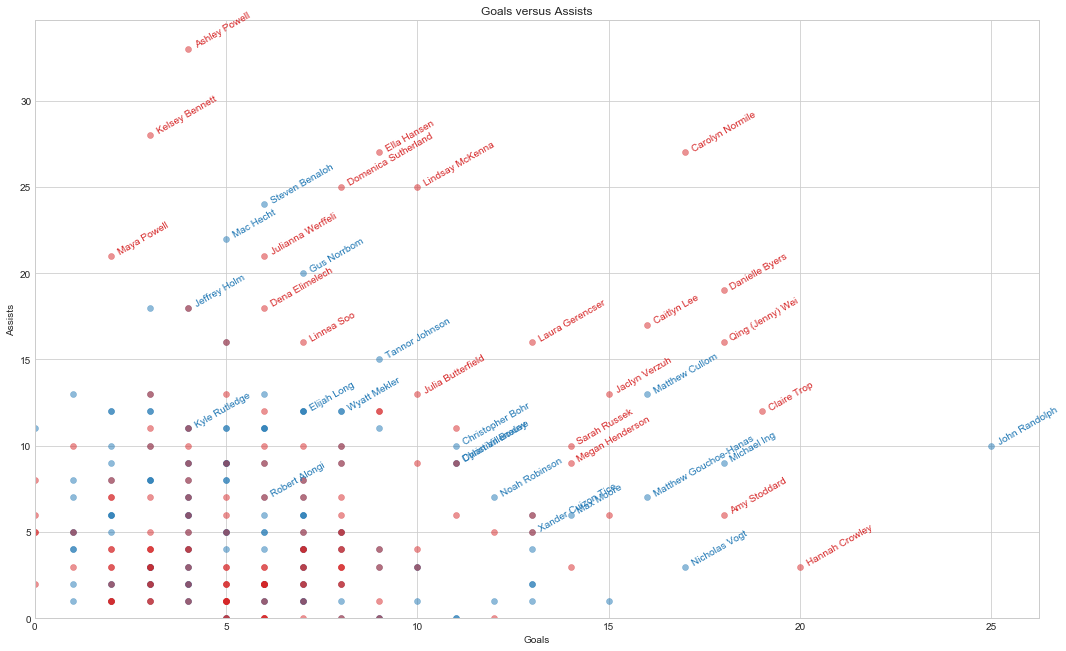

In [10]:
# Plot goals versus assists, labelling the top 20 performers of both genders
fig, ax = plt.subplots(figsize=(18, 11))
ax.plot(m2018stats.Gs, m2018stats.As, "o", color=sns_blue, **style_args)
ax.plot(w2018stats.Gs, w2018stats.As, "o", color=sns_red, **style_args)
ax.set_xlabel("Goals")
ax.set_ylabel("Assists")
ax.set_title("Goals versus Assists")
for _, row in m2018stats.head(20).iterrows():
  adjustment = 0.2
  ax.annotate(row["Name"], xy=(row["Gs"] + adjustment, row["As"] + adjustment),
              ha='left', va='center', rotation=30, wrap=True, color=sns_blue)
for _, row in w2018stats.loc[w2018stats["Gs"] + w2018stats["As"] > 22].iterrows():
  adjustment = 0.2
  ax.annotate(row["Name"], xy=(row["Gs"] + adjustment, row["As"] + adjustment),
              ha='left', va='center', rotation=30, wrap=True, color=sns_red)
ax.set_xlim(0)
ax.set_ylim(0)

In [11]:
m2018stats["Gender"] = "Men"
w2018stats["Gender"] = "Women"
stats2018 = pd.concat([m2018stats, w2018stats])

### Assists versus turnovers:

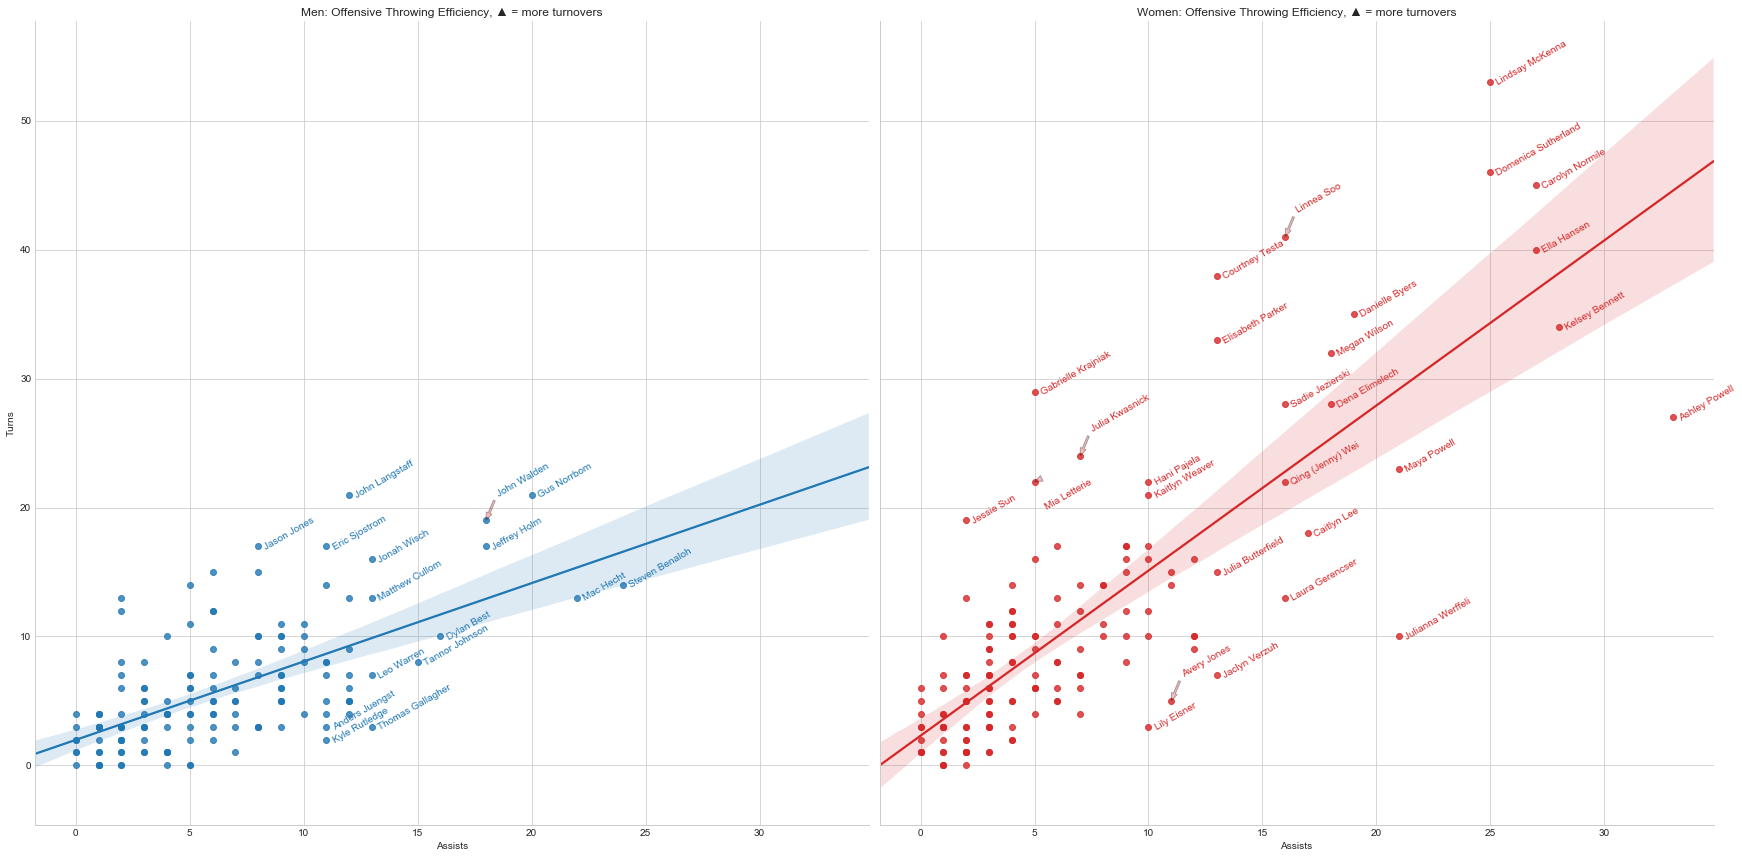

In [12]:
# Plot As versus turns, labelling the top values of both genders
# Using the top 500 players by fantasy (at least 2 scores/assists) to prune some of the null data
g = sns.lmplot("As", "Ts", stats2018.head(500), hue="Gender", col="Gender",
               size=12, palette={"Men": sns_blue, "Women": sns_red})

# Fix annotations for men:
ax = g.axes[0, 0]
ax.set_title(u"Men: Offensive Throwing Efficiency, ▲ = more turnovers")
ax.set_xlabel("Assists")
ax.set_ylabel("Turns")

def shift_annotation(name, x, y):
    if name in ("John Walden",):
        return (x + 0.5, y + 2.0)
    return None

for _, row in m2018stats[(m2018stats.As > 12) | (m2018stats.Ts > 15) |
                         ((m2018stats.As == 11) & (m2018stats.Ts < 4))].iterrows():
  adj = 0.3
  x = row["As"]
  y = row["Ts"]
  # Couple of special cases for people whose names are obscured
  xytext = shift_annotation(row["Name"], x, y)
  if xytext:
    ax.annotate(row["Name"], xy=(x, y), xytext=xytext,
                  arrowprops=dict(facecolor=sns_red, headwidth=6, headlength=8, width=2.0, alpha=0.3),
                  ha='left', va='center', rotation=30, wrap=True, color=sns_blue)
  else:  
    ax.annotate(row["Name"], xy=(x + adj, y + adj - 0.4),
                  ha='left', va='center', rotation=30, wrap=True, color=sns_blue)

# Fix annotations for women:
ax = g.axes[0, 1]
ax.set_title(u"Women: Offensive Throwing Efficiency, ▲ = more turnovers")
ax.set_xlabel("Assists")
# ax.set_ylabel("Turns")

def shift_annotation(name, x, y):
    if name in ("Linnea Soo", "Julia Kwasnick", "Avery Jones"):
        return (x + 0.5, y + 2.0)
    elif name in ("Mia Letterie",):
        return (x + 0.5, y - 2.0)
    return None

for _, row in w2018stats[(w2018stats.As > 12) | (w2018stats.Ts > 17) | 
                         ((w2018stats.As > 9) & (w2018stats.Ts < 8)) 
                        ].iterrows():
  adj = 0.3
  x = row["As"]
  y = row["Ts"]
  # Couple of special cases for people whose names are obscured
  xytext = shift_annotation(row["Name"], x, y)
  if xytext:
    ax.annotate(row["Name"], xy=(x, y), xytext=xytext,
                  arrowprops=dict(facecolor=sns_red, headwidth=6, headlength=8, width=2.0, alpha=0.3),
                  ha='left', va='center', rotation=30, wrap=True, color=sns_red)
  else:  
    ax.annotate(row["Name"], xy=(x + adj, y + adj - 0.4),
                  ha='left', va='center', rotation=30, wrap=True, color=sns_red)

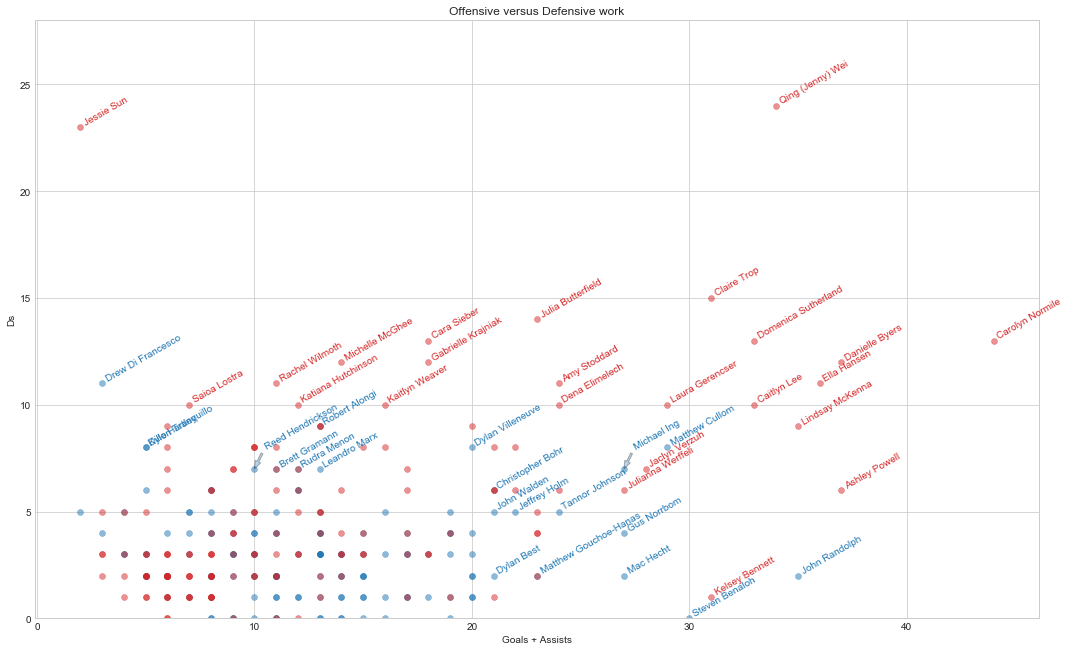

In [13]:
# Plot goals+assists versus Ds, labelling the top 20 performers of both genders
fig, ax = plt.subplots(figsize=(18, 11))
ax.plot(m2018stats.Gs + m2018stats.As, m2018stats.Ds, "o", color=sns_blue, **style_args)
ax.plot(w2018stats.Gs + w2018stats.As, w2018stats.Ds, "o", color=sns_red, **style_args)
ax.set_xlabel("Goals + Assists")
ax.set_ylabel("Ds")
ax.set_title("Offensive versus Defensive work")
ax.set_ylim(0, 28)
for _, row in w2018stats[(w2018stats.Ds > 9) |
                         (w2018stats.Gs + w2018stats.As > 25)].iterrows():
  adjustment = 0.2
  x, y = row["Gs"] + row["As"], row["Ds"]
  color = sns_red
  ax.annotate(row["Name"], xy=(x + adjustment,y  + adjustment),
              ha='left', va='center', rotation=30, wrap=True, color=color)

def shift_annotation(name, x, y):
    if name in ("Michael Ing", "Reed Hendrickson"):
        return (x + 0.5, y + 1.0)
    return None

for _, row in m2018stats[(m2018stats.Ds > 6) |
                         (m2018stats.Gs + m2018stats.As > 20)].iterrows():
  adjustment = 0.2
  x, y = row["Gs"] + row["As"], row["Ds"]
  xytext = shift_annotation(row["Name"], x=x, y=y)
  if xytext:
    ax.annotate(row["Name"], xy=(x, y), xytext=xytext,
                arrowprops=dict(facecolor=sns_blue, headwidth=6, headlength=8, width=2.0, alpha=0.3),
                ha='left', va='center', rotation=30, wrap=True, color=sns_blue)
  else:
    ax.annotate(row["Name"], xy=(x + adjustment,y  + adjustment),
                ha='left', va='center', rotation=30, wrap=True, color=sns_blue)